# Conditional stalling for randomly distributed addresses

## Publication
This work has an associated publication:

Title: "Boosting performance of HLS dataflows with datadependencies using fast conditional stalling"

Authors: Tobías Alonso, Gustavo Sutter, Sergio Lopez-Buedo, and Jorge E. López de Vergara

In [ ]:
import numpy as np
from multiprocessing import Pool
from tqdm import tqdm
import matplotlib.pyplot as plt
from conditional_stalling import *

In [2]:
import matplotlib
font = {'family':'serif','weight':'normal','size':10}
matplotlib.rc('font', **font)

In [3]:
# %matplotlib qt
np.random.seed(0)

## Generate Random distribution

In [4]:
C_idx_high =10
C_list= [2**i for i in range(1,C_idx_high+1)] # id range size  

np.random.seed(0)
CDFs = dict()
PDFs = dict()
for C in C_list:
  hist = [np.random.randint(1,high=2**10) for i in range(C)]
  hist = np.array(hist)/sum(hist)
  cdf = []
  acc = 0
  for p in hist:
    acc += p
    cdf += [acc]
  
  PDFs[C] = hist
  CDFs[C] = cdf

## Av. II for different cardinalities

In [5]:

L_high = 15
nthr=4
SIZE_OF_SIM_BLOCK = 100000
Simulation_IIs = []
DD_axis = range(0,L_high+1)
for C in tqdm(C_list):
  CDF = CDFs[C]
  def test_kernel(x):
    return simulate_stall_stage(x,C,seed=0,num_of_elem=SIZE_OF_SIM_BLOCK,id_generator=lambda : rand_CDF(CDF))

  with Pool(processes=nthr) as p:
    res = p.map(test_kernel,DD_axis)
    Simulation_IIs += [res]

Simulation_IIs = np.array(Simulation_IIs)

100%|██████████| 10/10 [01:49<00:00, 10.94s/it]


## $\overline{II}_{sys}$ plot

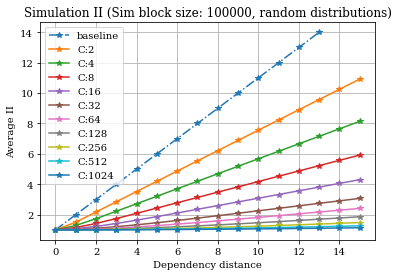

In [6]:
plt.figure()

plt.plot(range(0,L_high-1),range(1,L_high),"*-.", label="baseline")
dep_distance = [i for i in range(0,L_high+1)]
for c,C in enumerate(C_list):
  curve = Simulation_IIs[c]
  plt.plot(dep_distance,curve,"*-",label="C:%d"%C)
  

plt.legend()
plt.title("Simulation II (Sim block size: %d, random distributions)" % (SIZE_OF_SIM_BLOCK))
plt.xlabel("Dependency distance")
plt.ylabel("Average II")
plt.grid()

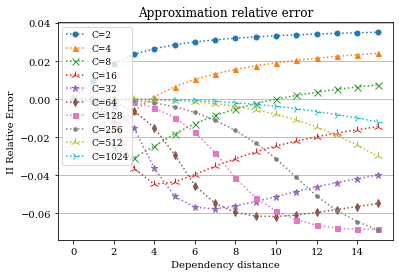

In [7]:
markers = ['o', '^','x','2',  '*', 'd', 's', '.','2','4',  '1', 'v', '^', '<', '>', '1', '2', '3', '4', 's', 'p', '*', 'h', 'H', '+', 'x', 'D', 'd', '|', '_']
#relative Error plot
fig = plt.figure()
plt.title("Approximation relative error")
plt.xlabel("Dependency distance")
plt.ylabel("II Relative Error")
plt.grid(True,axis='y')
marker_idx=0
L_high = 15
for C_idx in range(C_idx_high):
  C = 2**(C_idx+1)
  max_L = L_high
  curve = Simulation_IIs[C_idx,:max_L+1]
  L_axis = range(0,max_L+1)
  Stages = [l+1 for l in L_axis]
  Pc = sum( PDFs[C][symb]**2 for symb in range(C))
  curve_approx = [ approx_II(l,Pc) for l in L_axis]
  diff = [(a-b)/a for a,b in zip(curve,curve_approx)]
  markersize = 5 if markers[marker_idx] in ['o', '^','d','s'] else (9 if markers[marker_idx]=='2' else 7)
  plt.plot(L_axis,diff,markers[marker_idx]+":",markersize=markersize,label="C=%d"%C)
  marker_idx +=1
  
plt.legend(prop={'size': 9},loc='upper left')